<a href="https://colab.research.google.com/github/Dav-web/MSC.-Thesis/blob/main/Topic_Models_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Topic Modeling Using LDA

In [2]:
# mount the google drive to read in data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# define file path on google drive
root_path = '/content/gdrive/My Drive/covidvaccine.csv'

## Import LIbraries and Helper Functions

In [4]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
print(gensim.__version__)
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

#for text cleaning
import string
import re
import nltk
import itertools as it
import logging
import os
import sys
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter
!pip install emoji
import emoji
nltk.download('words')
words = set(nltk.corpus.words.words())

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
#!pip install pyLDAvis.gensim
!pip install -U nlplot
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

3.6.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 175 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=fae721c97ce1fbe729841c9f42a6f1288e2eb977cac1fa28519ea4f83a6603fb
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=33494f59

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


     |████████████████████████████████| 967 kB 4.3 MB/s 


## Read in data from the data source (Google drive)

In [6]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(root_path)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house from North Eastern India.,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine,['CovidVaccine'],Twitter Web App,False
1,Shubham Gupta,NaN,I will tell about all experiences of my life from my videos hope that you all like the videos 🙂,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY,"['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']",Twitter for Android,False
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI,NaN,Twitter Web App,False
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls,NaN,Twitter for Android,False
4,Ann-Maree O’Connor,"Adelaide, South Australia","Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.",24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj,NaN,Twitter Web App,False


## Data Cleaning and Preprocessing

In [7]:
import pandas as pd
import re
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet, deacc=True, min_len=3):
            result.append(token)
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
df['tweet'] = df['text'].map(lambda x: preprocess_tweet(x))

In [9]:
df[['tweet', 'text']].head()

,tweet,text
0,australia manufacture covid vaccine and give the citizens for free cost afp quotes prime minister,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine
1,australia doing very good,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY
2,deaths due covid affected countries read more,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI
3,stay safe amp,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls
4,this what passes for leadership our country voucher for something that,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj


In [10]:
# Convert to list
data = df['tweet'].values.tolist()
data[:1]

['australia manufacture covid vaccine and give the citizens for free cost afp quotes prime minister']

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['a', 'u', 's', 't', 'r', 'a', 'l', 'i', 'a', ' ', 'm', 'a', 'n', 'u', 'f', 'a', 'c', 't', 'u', 'r', 'e', ' ', 'c', 'o', 'v', 'i', 'd', ' ', 'v', 'a', 'c', 'c', 'i', 'n', 'e', ' ', 'a', 'n', 'd', ' ', 'g', 'i', 'v', 'e', ' ', 't', 'h', 'e', ' ', 'c', 'i', 't', 'i', 'z', 'e', 'n', 's', ' ', 'f', 'o', 'r', ' ', 'f', 'r', 'e', 'e', ' ', 'c', 'o', 's', 't', ' ', 'a', 'f', 'p', ' ', 'q', 'u', 'o', 't', 'e', 's', ' ', 'p', 'r', 'i', 'm', 'e', ' ', 'm', 'i', 'n', 'i', 's', 't', 'e', 'r']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'RT', 'amp', 'co', 'afp']) 

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['vaccine', 'give', 'citizen', 'cost', 'quote']]


## LDA Model

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('citizen', 1), ('cost', 1), ('give', 1), ('quote', 1), ('vaccine', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=70, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 70 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(66,
  '0.125*"million" + 0.099*"retweet" + 0.052*"milestone" + 0.044*"track" + '
  '0.037*"spot" + 0.035*"capacity" + 0.033*"tip" + 0.029*"manufacturer" + '
  '0.027*"candidate" + 0.026*"draw"'),
 (10,
  '0.135*"research" + 0.092*"hand" + 0.087*"history" + 0.046*"interview" + '
  '0.040*"otherwise" + 0.029*"sort" + 0.023*"definition" + 0.020*"wash" + '
  '0.018*"modi" + 0.016*"com"'),
 (57,
  '0.094*"service" + 0.091*"accord" + 0.085*"remain" + 0.060*"authorize" + '
  '0.056*"office" + 0.048*"society" + 0.031*"beat" + 0.022*"employment" + '
  '0.021*"afternoon" + 0.020*"file"'),
 (67,
  '0.243*"boost" + 0.114*"omicron" + 0.082*"announce" + 0.060*"less" + '
  '0.059*"transmission" + 0.052*"suffer" + 0.038*"near" + 0.030*"donate" + '
  '0.016*"train" + 0.012*"toll"'),
 (2,
  '0.110*"treatment" + 0.090*"date" + 0.072*"location" + 0.051*"currently" + '
  '0.051*"vaxxer" + 0.038*"involve" + 0.038*"ignore" + 0.037*"inform" + '
  '0.036*"consent" + 0.033*"majority"'),
 (1,
  '0.094*"pandemi

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.703986733644518

Coherence Score:  0.41443594867222083


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
55     0.054669  0.442534       1        1  8.095916
47     0.185282  0.088762       2        1  4.397587
16    -0.168590  0.305200       3        1  2.356357
44    -0.109131  0.528108       4        1  2.198821
68     0.512266 -0.141438       5        1  2.109874
...         ...       ...     ...      ...       ...
2      0.109770 -0.087780      66        1  0.636738
67    -0.455709 -0.181841      67        1  0.631655
57    -0.016511  0.180559      68        1  0.606679
10     0.059791  0.306890      69        1  0.558953
66     0.242168 -0.075807      70        1  0.543804

[70 rows x 5 columns], topic_info=             Term          Freq         Total Category  logprob  loglift
452          dose  71024.000000  71024.000000  Default  30.0000  30.0000
4         vaccine  74746.000000  74746.000000  Default  29.0000  29.0000
105           get  57368.000000  57368.000000  Default  28.0000  28.0000
9119         slot  31552.000000  31552.000000  Default  27.0000  27.0000
158        people  25537.000000  25537.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
4438   assessment     90.364458     91.193110  Topic70  -4.8691   5.2052
5210       racism     87.012196     87.840849  Topic70  -4.9069   5.2049
877            ad     85.174135     86.002787  Topic70  -4.9283   5.2047
11842       cowin     83.092200     83.920853  Topic70  -4.9530   5.2044
2615    indemnity     79.162451     79.991103  Topic70  -5.0015   5.2039

[2131 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
24       26  0.995389     ability
2547     14  0.994240    abortion
1955     14  0.986710      abroad
787      28  0.999601  absolutely
2368     44  0.995527       abuse
...     ...       ...         ...
36       19  0.999857         yet
1054     26  0.996364       youth
844      64  0.996644     youtube
4062      6  0.993073         yrs
5234     47  0.997633        zoom

[2101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[56, 48, 17, 45, 69, 40, 37, 61, 42, 20, 27, 39, 33, 46, 29, 70, 23, 8, 9, 49, 38, 32, 31, 6, 51, 47, 10, 53, 66, 65, 44, 12, 21, 14, 4, 16, 19, 5, 15, 64, 63, 36, 60, 24, 22, 13, 55, 18, 59, 30, 43, 26, 34, 35, 41, 50, 25, 52, 54, 62, 57, 1, 7, 28, 2, 3, 68, 58, 11, 67])

### LDA Model Hyperparameter Tuning

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 123)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [ ]:
model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus, texts = data_lemmatized, start = 200, limit = 210, step = 1)


model created
0.5563076328936742
model created
0.5623808760459853
model created
0.5612069680405515
model created
0.5469491070264754
model created
0.561525669915305
model created
0.543809572695581
model created
0.5625735919284346
model created
0.5510233993496877
model created
0.5484226124977255
model created
0.5461563129630038


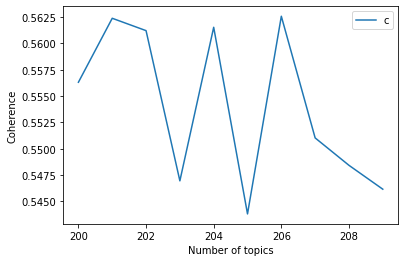

In [ ]:
limit, start, step = 210, 200, 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(82,
  '0.311*"end" + 0.101*"reaction" + 0.083*"delay" + 0.048*"cut" + 0.047*"operate" + 0.032*"truly" + 0.030*"lady" + 0.017*"fun" + 0.015*"inspire" + 0.012*"slow"'),
 (172,
  '0.089*"law" + 0.074*"profit" + 0.070*"partner" + 0.062*"terrorist" + 0.053*"injury" + 0.048*"boy" + 0.038*"conversation" + 0.038*"border" + 0.021*"expand" + 0.018*"pfizer"'),
 (157,
  '0.358*"age" + 0.153*"worker" + 0.149*"never" + 0.079*"vaxxe" + 0.058*"else" + 0.023*"frontline" + 0.021*"employer" + 0.010*"suspect" + 0.009*"vaxe" + 0.004*"storm"'),
 (171,
  '0.109*"leader" + 0.086*"suggest" + 0.076*"arrest" + 0.074*"police" + 0.064*"lockdown" + 0.055*"challenge" + 0.050*"celebrate" + 0.049*"hard" + 0.036*"reality" + 0.015*"ton"'),
 (141,
  '0.118*"rush" + 0.103*"jabbed" + 0.052*"quite" + 0.043*"excuse" + 0.040*"industry" + 0.030*"file" + 0.026*"restrict" + 0.018*"afford" + 0.017*"achy" + 0.013*"sum"'),
 (123,
  '0.150*"suffer" + 0.087*"enough" + 0.033*"earlier" + 0.024*"initially" + 0.021*"flow" + 0.018*"with

In [ ]:
lda_display = gensimvis.prepare(model_list[index], corpus, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,93.0,0.0430,"give, save, jump, gun, criminal, shoulder, rfk, footballer, closure, hashtag","[vaccine, give, citizen, cost, quote]"
1,1,9.0,0.0447,"death, case, update, total, confirm, recover, latest, grasp, identity, hemorrhage",[]
2,2,148.0,0.0509,"get, stay, player, bed, soldier, vaccine, opposition, load, boostere, chart","[death, affect, country, read]"
3,3,100.0,0.0447,"set, mother, example, leadership, super, price, delivery, horse, network, bother",[stay]
4,4,66.0,0.0447,"provide, enter, income, vaer, covaxin, ut, syndrome, select, dosage, evade","[pass, leadership, country, voucher]"
5,5,198.0,0.0385,"work, let, pace, environment, grandparent, penis, dupe, priest, stoke, mid","[syndrome, child, mi, disease]"
6,6,37.0,0.0414,"country, decision, access, near, hero, minister, toll, therefore, indeed, trouble",[]
7,7,11.0,0.0466,"visit, hear, better, send, sense, focus, space, none, politic, blow","[let, would, party, vaccine, rush, minimally, test, come]"
8,8,183.0,0.0509,"question, tweet, contract, camp, best, stuff, balance, murder, hospitalisation, protocol","[country, ability, make, locally, force, other]"
9,9,113.0,0.0430,"trial, old, avoid, last, totally, stage, maintain, rat, borough, alert","[week, hear, episode]"


In [ ]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)

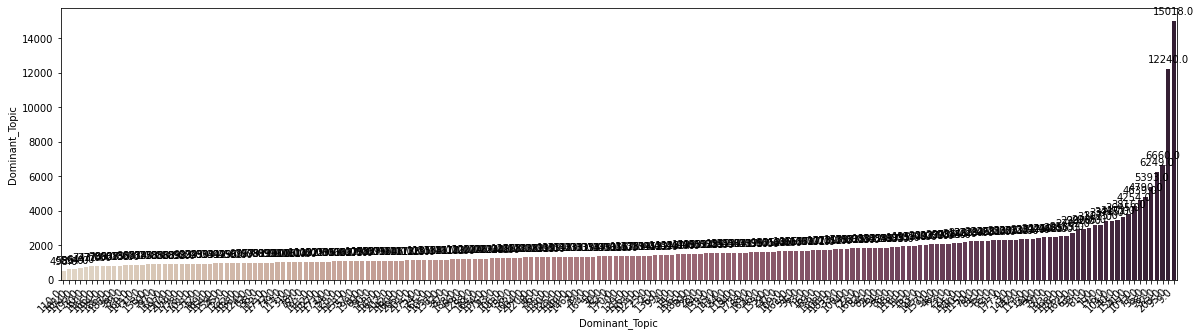

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,5))
ax = sns.barplot(x=topic_counts.index, y=topic_counts, data=topic_counts,  palette="ch:.25")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax = ax.set_xticklabels(topic_counts.index, rotation = 45, ha="right")

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(24)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1762,"break, cost, discussion, factor, asap, survey, tune, unvaxxe, mislead, rapidly","[travel, industry, face, setback, shut, flight, hotel]"
1,1.0,0.1508,"live, hold, expect, click, meeting, street, music, early, expire, timeline","[apology, dance, move, get, week]"
2,2.0,0.1992,"begin, misconception, obtain, rddose, coin, intranasal, tunnel, cord, vigilant, autumn","[open, ace, pharmacy, get, vaccinate, area, drop, today, today]"
3,3.0,0.1361,"would, mom, prefer, sport, stream, deport, quarantine, conservative, cousin, ministry","[emergency, feel, bowl, get]"
4,4.0,0.1579,"believe, efficacy, deny, victim, vax, ignorance, initiative, top, father, cult","[offer, dose, vaccine, today, let, reiver]"
5,5.0,0.1994,"together, failure, pressure, notice, danger, trend, shop, language, parliament, sooner","[present, vaccine, booster, fast, track, month]"
6,6.0,0.1434,"today, controversy, nhs, mass, acquire, outreach, expiry, terror, relation, memo","[take, look, open, stoneleigh, warwickshire]"
7,7.0,0.1990,"drop, office, involve, grant, race, crowd, vaxer, sadly, entry, censor","[researcher, say, could, see, case, rate, rise]"
8,8.0,0.1474,"hit, solution, coincidence, sort, tuition, clear, contradict, internet, evil, frequently","[people, argue, mortality, rate, look, mortality, rate, disease, vaccinate, rubella]"
9,9.0,0.2572,"death, case, update, total, confirm, recover, latest, grasp, identity, hemorrhage","[bioethic, question, emerge, drug, use, treatment]"


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,93.0,"give, save, jump, gun, criminal, shoulder, rfk, footballer, closure, hashtag",1338.0,0.0038
1.0,9.0,"death, case, update, total, confirm, recover, latest, grasp, identity, hemorrhage",2462.0,0.0069
2.0,148.0,"get, stay, player, bed, soldier, vaccine, opposition, load, boostere, chart",1366.0,0.0038
3.0,100.0,"set, mother, example, leadership, super, price, delivery, horse, network, bother",2209.0,0.0062
4.0,66.0,"provide, enter, income, vaer, covaxin, ut, syndrome, select, dosage, evade",1381.0,0.0039
...,...,...,...,...
368583.0,NaN,NaN,NaN,NaN
368584.0,NaN,NaN,NaN,NaN
368585.0,NaN,NaN,NaN,NaN
368586.0,NaN,NaN,NaN,NaN


### Advanced LDA USING MALLET

In [15]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-03-16 16:31:06--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-03-16 16:31:07--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.65MB/s    in 2.7s    

2022-03-16 16:31:10 (5.65 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [16]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [20]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=106, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(90,
  [('follow', 0.16297670847197337),
   ('continue', 0.13155874072178142),
   ('rule', 0.043255694906577935),
   ('place', 0.042615817762989505),
   ('measure', 0.04012029690299462),
   ('remember', 0.03941643204504735),
   ('advice', 0.03487330432556949),
   ('guidance', 0.03218582032249808),
   ('nee', 0.02885845917583824),
   ('guideline', 0.021307908881494753)]),
 (92,
  [('government', 0.10264721772015127),
   ('push', 0.07839606218860676),
   ('force', 0.07413410168677592),
   ('fear', 0.05906717089861336),
   ('control', 0.05822678432078756),
   ('power', 0.04904255957740561),
   ('create', 0.030494027252536166),
   ('politician', 0.020829581607539466),
   ('threat', 0.019989195029713667),
   ('remove', 0.019689056966204453)]),
 (49,
  [('question', 0.2952714341279102),
   ('answer', 0.13980107795743735),
   ('join', 0.1264099572150914),
   ('expert', 0.06473301105739845),
   ('tonight', 0.031171861976996167),
   ('discuss', 0.027726843362782687),
   ('discussion', 0.026337

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=300, limit=310, step=1)

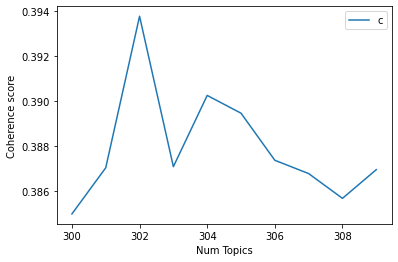

In [24]:
# Show graph
limit=310; start=300; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 300  has Coherence Value of 0.385
Num Topics = 301  has Coherence Value of 0.387
Num Topics = 302  has Coherence Value of 0.3938
Num Topics = 303  has Coherence Value of 0.3871
Num Topics = 304  has Coherence Value of 0.3902
Num Topics = 305  has Coherence Value of 0.3895
Num Topics = 306  has Coherence Value of 0.3874
Num Topics = 307  has Coherence Value of 0.3868
Num Topics = 308  has Coherence Value of 0.3857
Num Topics = 309  has Coherence Value of 0.3869


In [26]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(124,
  '0.063*"rule" + 0.055*"deny" + 0.051*"exemption" + 0.051*"reject" + '
  '0.050*"seek" + 0.049*"court" + 0.046*"request" + 0.029*"plea" + '
  '0.027*"mandate" + 0.027*"reason"'),
 (266,
  '0.566*"vaccine" + 0.226*"today" + 0.061*"reminder" + 0.015*"announcement" + '
  '0.010*"legend" + 0.008*"possibility" + 0.004*"sinovac" + 0.003*"moon" + '
  '0.003*"regard" + 0.002*"message"'),
 (206,
  '0.277*"clinic" + 0.148*"pop" + 0.071*"walk" + 0.066*"drop" + '
  '0.060*"tomorrow" + 0.056*"weekend" + 0.034*"appointment" + 0.027*"host" + '
  '0.023*"place" + 0.020*"info"'),
 (78,
  '0.360*"vaccine" + 0.136*"complete" + 0.107*"form" + 0.055*"fill" + '
  '0.038*"pill" + 0.031*"successfully" + 0.025*"congratulation" + '
  '0.017*"training" + 0.014*"consent" + 0.013*"survey"'),
 (30,
  '0.480*"vaccine" + 0.098*"hesitancy" + 0.040*"reason" + 0.020*"fuel" + '
  '0.019*"attention" + 0.018*"overcome" + 0.016*"combat" + 0.015*"lack" + '
  '0.015*"skepticism" + 0.014*"understanding"'),
 (77,
  '0.2

In [27]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,202.0,0.0172,"refuse, treatment, reason, cover, cost, insurance, company, deny, hospital, regime",australia manufacture covid vaccine and give the citizens for free cost afp quotes prime minister
1,1,0.0,0.0033,"arrive, deliver, batch, handle, consignment, box, flight, carry, movement, shipment",australia doing very good
2,2,176.0,0.0195,"affect, woman, impact, period, evidence, fertility, explain, cycle, man, change",deaths due covid affected countries read more
3,3,175.0,0.0229,"stay, home, tune, nee, forever, bind, order, leave, lock, date",stay safe amp
4,4,285.0,0.0216,"pass, test, place, therapy, gene, vaccine, benefit, product, vector, sample",this what passes for leadership our country voucher for something that
5,5,104.0,0.0195,"risk, benefit, increase, factor, put, associate, outweigh, complication, harm, pose",the multi system inflammatory syndrome children mis atypical kawasaki disease the
6,6,0.0,0.0033,"arrive, deliver, batch, handle, consignment, box, flight, carry, movement, shipment",
7,7,134.0,0.0151,"kid, parent, child, rush, meet, watch, share, include, trial, superhero",well let qualify that would anyone any party get vaccine rushed out and minimally tested coming from russia
8,8,193.0,0.0232,"country, world, develop, globally, patent, access, produce, recognise, property, block",most countries without the ability make locally will forced rely others like the china
9,9,238.0,0.0178,"hear, view, opinion, voice, reason, debate, argument, speak, express, viewer",zooms charts week hear episode


In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1693,"arrive, deliver, batch, handle, consignment, box, flight, carry, movement, shipment",the sustained efforts ensure smooth delivery medical essentials airports are applaudable today shipment boxes arrived from was promptly delivered the consignee
1,1.0,0.0867,"vaccine, figure, give, today, update, refer, kindly, back, minister, graph",today vaccine update for anyone who wants refer back previous days figures are above
2,2.0,0.1658,"roll, vote, plan, poll, ahead, sleeve, voter, election, party, pass",new jersey you live amp are against and have freedom you must vote murphy out his admin leaked his agenda planning implementing harsh and agenda post election vote murphy out vote murphy out
3,3.0,0.1050,"control, government, power, create, push, knowledge, attempt, fear, resist, abuse",evil controls our narratives via our media and institutions attempts override our common sense and logic and uses fear succeed none are alone unite with others have discussion use cash not digital
4,4.0,0.0668,"people, vaccinate, urge, asap, motivate, youngster, caution, strongly, successfully, parliament",india have successfully vaccinated over million people paving the way for safer and secure nation but this only the beginning and have long way urge you all come forward and get your covid vaccine


In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,202.0,"refuse, treatment, reason, cover, cost, insurance, company, deny, hospital, regime",20341.0,0.0552
1.0,0.0,"arrive, deliver, batch, handle, consignment, box, flight, carry, movement, shipment",808.0,0.0022
2.0,176.0,"affect, woman, impact, period, evidence, fertility, explain, cycle, man, change",1514.0,0.0041
3.0,175.0,"stay, home, tune, nee, forever, bind, order, leave, lock, date",1189.0,0.0032
4.0,285.0,"pass, test, place, therapy, gene, vaccine, benefit, product, vector, sample",767.0,0.0021
...,...,...,...,...
368583.0,20.0,"trump, code, election, save, lady, president, live, promo, supporter, suspend",NaN,NaN
368584.0,96.0,"week, appt, schedule, cancel, mom, mine, husband, finally, gap, hub",NaN,NaN
368585.0,248.0,"term, vaccine, effect, inform, include, covid, consent, worry, understand, gain",NaN,NaN
368586.0,11.0,"join, discussion, tomorrow, expert, host, discuss, tonight, panel, conversation, session",NaN,NaN
